<a href="https://colab.research.google.com/github/DanielhCarranza/Curso-Deep-Learning/blob/master/Signals_Processing_for_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal processing for ML

## Fast Fourier Transform
Fourier analysis is a method for expressing a function as a sum of periodic components, and for recovering the signal from those components. When both the function and its Fourier transform are replaced with discretized counterparts, it is called the discrete Fourier transform (DFT). The DFT has become a mainstay of numerical computing in part because of a very fast algorithm for computing it, called the Fast Fourier Transform (FFT)

In [ ]:
from scipy.fftpack import fft , ifft, ifftshift

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from lightgbm import LGBMClassifier
from collections import Counter


% matplotlib inline

In [ ]:
help(fft)

The real part of the complex value corresponds with the magnitude, and the imaginary part with the phase of the signal. Since we are only interested in the magnitude of the amplitudes, we use `np.abs()`` to take the real part of the frequency spectrum.

In [ ]:
def get_Fast_Fourier_Transform(X, T:int, N:int, Fs:int=None):
    """ Fast Fourier Transform 
    Args:
      X: function or signal: array
      T: period = 1/Fs
      N: Number of sample points
      Fs: sampling frequency
    Rerturn
    frequency_values 
    fft_values: vector of complex valued frequencies
    """
    if Fs != None:
      T=1/Fs
      
    frequency_values= np.linspace(0,1.0/(2.0*T), N//2) # we divide by 2, because of Nyquist 
    fft_values_ =fft(X)
    fft_values= 2.0/N * np.abs(fft_values_[0:N//2]) # after N//2 the values really doesn't matter 
    
    return frequency_values, fft_values
        

In [ ]:
t_n = 10 
N = 1000
T = t_n / N 
f_s = 1/T # 100hz sampling frequency

In [ ]:
x=np.linspace(0.0, N*T, N)
X =np.sin(25.0 * 2.0*np.pi*x) + 0.5*np.sin(40.0 * 2.0*np.pi*x)

frequency_values, fft_values= get_Fast_Fourier_Transform(X, T, N)    

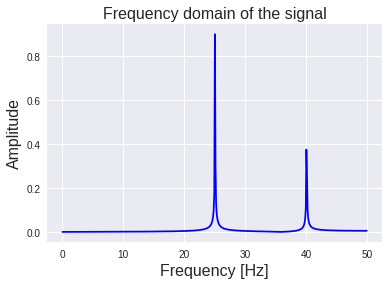

In [ ]:
plt.plot(frequency_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

## Auto-correlation of a Signal
The auto-correlation function calculates the correlation of a signal with a time-delayed version of itself. The idea behind it is that if a signal contain a pattern which repeats itself after a time-period of $\tau$ seconds, there will be a high correlation between the signal and a $\tau$ sec delayed version of the signal.

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:] 

In [ ]:
def get_autocorr_values(y_values, T, N):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * i for i in range(0, N)])
    return x_values, autocorr_values

In [ ]:
t_values, autocorr_values = get_autocorr_values(X, T, N)
 

In [ ]:
# def autocorrelation(x):
#     xp = ifftshift((x - np.average(x))/np.std(x))
#     n, = xp.shape
#     xp = np.r_[xp[:n//2], np.zeros_like(xp), xp[n//2:]]
#     f = fft(xp)
#     p = np.absolute(f)**2
#     pi = ifft(p)
#     return np.real(pi)[:n//2]/(np.arange(n//2)[::-1]+n//2)
# autocorr_values= autocorrelation(X)

Text(0, 0.5, 'Autocorrelation amplitude')

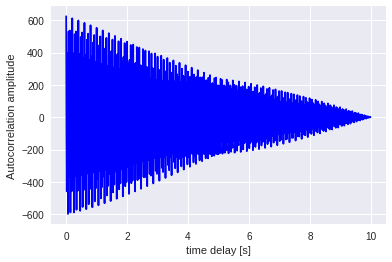

In [ ]:
plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')


## Power Spectral Density 
Power **spectral density function** (PSD) shows the strength of the variations(energy) as a function of frequency. In other words, it shows at which frequencies variations are strong and at which frequencies variations are weak. The unit of PSD is energy per frequency(width) and you can obtain energy within a specific frequency range by integrating PSD within that frequency range. Computation of PSD is done directly by the method called FFT or computing autocorrelation function


Similar to the FFT, it describes the frequency spectrum of a signal. But in addition to the FFT it also takes the power distribution at each frequency (bin) into account. Generally speaking the locations of the peaks in the frequency spectrum will be the same as in the FFT-case, but the height and width of the peaks will differ. The surface below the peaks corresponds with the power distribution at that frequency.

*Note:* 
Power Spectral Density is the Fourier Transform of the autocorrelation function of a signal. First compute the auto correlation function and then compute its Fourier Transform

In [ ]:
from scipy.signal import welch

In [ ]:
help(welch)

In [ ]:

t_n = 10
N = 1000
T = t_n / N
f_s = 1/T
 
x=np.linspace(0.0, N*T, N)
X =np.sin(25.0 * 2.0*np.pi*x) + 0.5*np.sin(40.0 * 2.0*np.pi*x)


In [ ]:
f_values, psd_values = welch(X, fs=f_s)



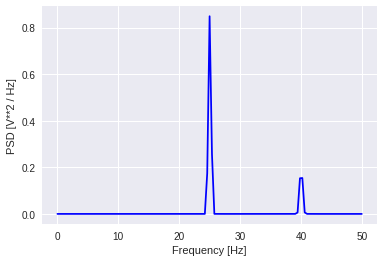

In [ ]:
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()

## Statistical parameter estimation and feature extraction


We can calculate the FFT, PSD and the auto-correlation of each signal and use the x and y coordinates of the peaks as input for our classifier.

![alt text](http://ataspinar.com/wp-content/uploads/2018/01/signal_to_matrix2-1024x638.png)

### Dataset Human Activity Recognition with Smartphones
This dataset contains measurements done by 30 people between the ages of 19 to 48. The measurements are done with a smartphone placed on the waist while doing one of the following six activities:

* walking,
* walking upstairs,
* walking downstairs,
* sitting,
* standing or
* laying.

The measurements are done at a constant rate of 50 Hz. After filtering out the noise, the signals are cut in fixed-width windows of 2.56 sec with an overlap of 1.28 sec. Each signal will therefore have 50 x 2.56 = 128 samples in total.

The smartphone measures three-axial linear body acceleration, three-axial linear total acceleration and three-axial angular velocity. So per measurement, the total signal consists of nine components

The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.


In [ ]:
# upload your kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

# download dataset 
# ! kaggle datasets download -d uciml/human-activity-recognition-with-smartphones
! unzip human-activity-recognition-with-smartphones.zip

Archive:  human-activity-recognition-with-smartphones.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from lightgbm import LGBMClassifier
from collections import Counter


In [ ]:
train=pd.read_csv('train.csv')
test= pd.read_csv('test.csv')


In [ ]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [ ]:
labels= train.iloc[:,-1]
train=  train.iloc[:,:-2]
test_labels= test.iloc[:,-1]
test=  test.iloc[:,:-2]


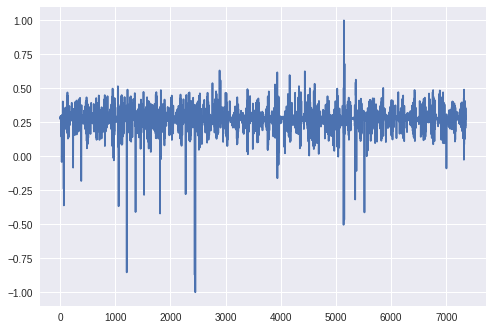

In [ ]:
t=np.arange(0,len(train.iloc[:,0]),1)
plt.plot(t,train.iloc[:,0])

In [ ]:
print(f'Activities {set(labels)} ')
labels.value_counts()

Activities {'LAYING', 'WALKING_UPSTAIRS', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS'} 


LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [ ]:
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in train.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyGyro,79
fBodyAcc,79
fBodyAccJerk,79
tBodyAcc,40
tBodyAccJerk,40
tBodyGyro,40
tBodyGyroJerk,40
tGravityAcc,40
fBodyBodyGyroJerkMag,13
fBodyBodyGyroMag,13


### Model without preproccessing

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
 

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(train, labels)



In [ ]:
sensor=np.expand_dims(X_test.iloc[0,:],axis=0)
predecir_sensor= modelo.predict(sensor)

In [ ]:

pred = modelo.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:

print("Accuracy on training set is : {:.4f}".format(clf.score(train, labels)))
print("Accuracy on test set is : {:.4f}".format(clf.score(test, test_labels)))
Y_test_pred = clf.predict(test)
print(classification_report(test_labels, Y_test_pred))

### Model  with Principal Component Analysis

In [ ]:
train=pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

data = pd.concat([train, test], axis=0).reset_index(drop=True)

In [ ]:
pca_data = data.iloc[:,:-2].copy()
labels = data.iloc[:,-1]

# Scale data
scl = StandardScaler()
pca_data = scl.fit_transform(pca_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
pca_data = pca.fit_transform(pca_data)


# Encode labels 
enc = LabelEncoder()
label_encoded = enc.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(pca_data, label_encoded, random_state=3)


#### LGBM Classifier with PCA

In [ ]:
# Create the model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

In [ ]:
y_pred=lgbm.predict(X_test)
score = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(y_test, y_pred))

Accuracy on testset:	0.9553

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       502
           1       0.92      0.87      0.89       443
           2       0.89      0.93      0.91       457
           3       0.99      0.98      0.99       446
           4       0.98      0.97      0.98       343
           5       0.96      0.98      0.97       384

   micro avg       0.96      0.96      0.96      2575
   macro avg       0.96      0.96      0.96      2575
weighted avg       0.96      0.96      0.96      2575



#### Random Forest Classifier with PCA

In [ ]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
print("Accuracy on training set is : {:.4f}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {:.4f}".format(clf.score(X_test, y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(y_test, Y_test_pred))

Accuracy on training set is : 1.0000
Accuracy on test set is : 0.9429
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       502
           1       0.93      0.83      0.88       443
           2       0.87      0.94      0.90       457
           3       0.97      0.98      0.97       446
           4       0.96      0.95      0.95       343
           5       0.96      0.97      0.96       384

   micro avg       0.94      0.94      0.94      2575
   macro avg       0.94      0.94      0.94      2575
weighted avg       0.94      0.94      0.94      2575

